### LSTM Example - Time Series Data ####

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


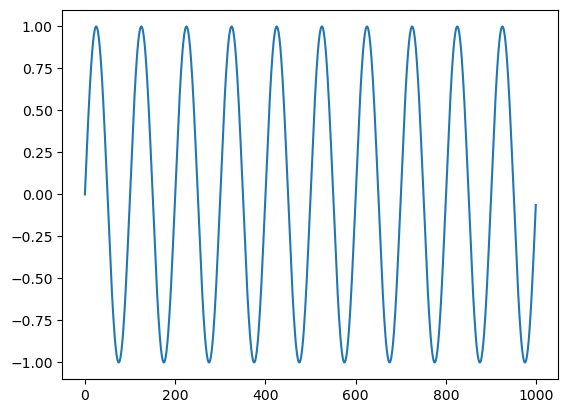

In [2]:
# Create a sinewave

def generate_sine_wave(periods, points_per_period, amplitude=1):
    points = np.arange(periods * points_per_period)
    x = (2 * np.pi) * points / points_per_period
    return amplitude * np.sin(x)

data = generate_sine_wave(10, 100)
plt.plot(data)
plt.show()

In [29]:
# Prepare data

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 25
X, y = create_sequences(data, seq_length)

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

print(f"Processed Data:\nX:\n{X[:3]}\nand y:\n{y[:2]}\n{y.shape}")

Processed Data:
X:
tensor([[0.0000, 0.0628, 0.1253, 0.1874, 0.2487, 0.3090, 0.3681, 0.4258, 0.4818,
         0.5358, 0.5878, 0.6374, 0.6845, 0.7290, 0.7705, 0.8090, 0.8443, 0.8763,
         0.9048, 0.9298, 0.9511, 0.9686, 0.9823, 0.9921, 0.9980],
        [0.0628, 0.1253, 0.1874, 0.2487, 0.3090, 0.3681, 0.4258, 0.4818, 0.5358,
         0.5878, 0.6374, 0.6845, 0.7290, 0.7705, 0.8090, 0.8443, 0.8763, 0.9048,
         0.9298, 0.9511, 0.9686, 0.9823, 0.9921, 0.9980, 1.0000],
        [0.1253, 0.1874, 0.2487, 0.3090, 0.3681, 0.4258, 0.4818, 0.5358, 0.5878,
         0.6374, 0.6845, 0.7290, 0.7705, 0.8090, 0.8443, 0.8763, 0.9048, 0.9298,
         0.9511, 0.9686, 0.9823, 0.9921, 0.9980, 1.0000, 0.9980]])
and y:
tensor([1.0000, 0.9980])
torch.Size([1075])


In [4]:
# Define LSTM architecture
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        self.hidden = tuple(h.detach() for h in self.hidden)  # Detach the hidden state from the graph
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]


By detaching the hidden state from the computation graph, you ensure that the memory is properly released, and you avoid the RuntimeError

In [5]:
# Train the model

model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
losses = []

epochs = 300

for epoch in range(epochs):
    for i, seq in enumerate(X):
        y_pred = model(seq)
        y_true = y[i].view(-1)
        #print(y_pred.size(),y_true.size())

        loss = criterion(y_pred, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


Epoch 10, Loss: 8.505066216457635e-05
Epoch 20, Loss: 9.503728506388143e-06
Epoch 30, Loss: 0.06502227485179901
Epoch 40, Loss: 0.00014714493590872735
Epoch 50, Loss: 0.0015634563751518726
Epoch 60, Loss: 0.000631751143373549
Epoch 70, Loss: 1.3996551615491626e-06
Epoch 80, Loss: 0.00014056732470635325
Epoch 90, Loss: 1.3528407180274371e-05
Epoch 100, Loss: 0.0007575772469863296
Epoch 110, Loss: 0.0002566271577961743
Epoch 120, Loss: 5.308496838551946e-06
Epoch 130, Loss: 1.741992491588462e-05
Epoch 140, Loss: 8.417676326644141e-06
Epoch 150, Loss: 2.2203128082765033e-06
Epoch 160, Loss: 0.0002166123886127025
Epoch 170, Loss: 9.53688140725717e-05
Epoch 180, Loss: 9.056137059815228e-06
Epoch 190, Loss: 1.032975887937937e-05
Epoch 200, Loss: 6.281454261625186e-05
Epoch 210, Loss: 1.0774380825750995e-05
Epoch 220, Loss: 9.488608338870108e-05
Epoch 230, Loss: 1.4672330507892184e-05
Epoch 240, Loss: 4.2708867908913817e-07
Epoch 250, Loss: 0.0005798435886390507
Epoch 260, Loss: 1.34446263473

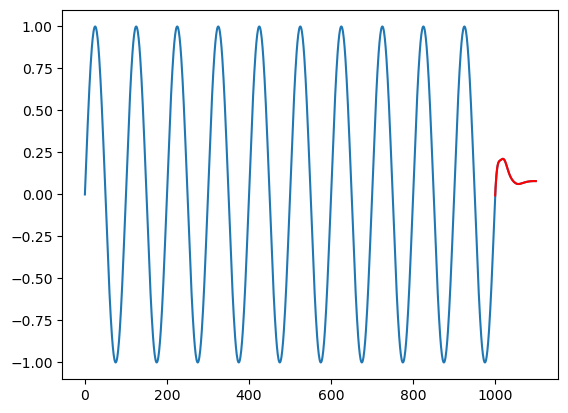

In [6]:
# Forecast

future_steps = 100
predictions = []

with torch.no_grad():
    for i in range(future_steps):
        seq = torch.FloatTensor(data[-seq_length:])
        pred = model(seq)
        predictions.append(pred.item())
        data = np.append(data, pred.item())

plt.plot(data)
plt.plot(range(len(data)-future_steps, len(data)), predictions, color='red')
plt.show()
